# Import Modules

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
tf.keras.utils.set_random_seed(42)


In [20]:
# Load the dataset into a DataFrame
df = pd.read_csv('datasets/cb513.csv')

# Filter to keep only rows with all 1.0s in cb513_mask
mask_filter = df['cb513_mask'].apply(lambda x: all(float(val) == 1.0 for val in x.split()))
filtered_df = df[mask_filter]

# Select only the required columns: input (primary sequence), dssp3 (secondary structure), and cb513_mask
filtered_df = filtered_df[['input', 'dssp3', 'cb513_mask']]

# Save the filtered dataset to a file in the desired format
with open('datasets/cb513.txt', 'w') as f:
    # Iterate over the rows of the DataFrame
    for _, row in filtered_df.iterrows():
        sequence = row['input'] # primary sequence
        # Convert secondary structure to the format used in our dataset: h,e,_
        structure = row['dssp3'].replace('H', 'h').replace('E', 'e').replace('C', '_') 
        mask = row['cb513_mask']
    
        # Check if the mask contains all 1.0s
        if all(float(val) == 1.0 for val in mask.split()):
            f.write('<>\n')
            for aa, ss in zip(sequence, structure):
                f.write(f'{aa} {ss}\n')
            f.write('<end>\n')

# Import Dataset

In [25]:
# convert a sequence of amino acids to a one-hot encoded matrix
def one_hot_encode(seq, vocab):
    # Create a matrix of zeros, with dimensions len(seq) x len(vocab)
    one_hot = np.zeros((len(seq), len(vocab)), dtype=np.float32)
    # Iterate over the sequence and set the appropriate elements to 1.0
    for i, char in enumerate(seq):
        if char in vocab:
            one_hot[i, vocab.index(char)] = 1.0
    return one_hot


# prepare data to enter neural network
def prepare_data(filepath, window_size=13):
    sequences = []
    structures = []
    current_seq = []
    current_struct = []
    processing_sequence = False  # Track when inside a sequence block

    with open(filepath, 'r') as file:
        for line in file:
            line = line.strip()
            if line == '<>': # Sequence separator
                if processing_sequence: 
                    if current_seq and current_struct:
                        seq_encoded = one_hot_encode(current_seq, aa_vocab) # One-hot encode sequence
                        struct_encoded = one_hot_encode(current_struct, structure_vocab) # One-hot encode structure

                        # Apply sliding window of determined size
                        for i in range(len(seq_encoded) - window_size + 1):
                            window = seq_encoded[i:i + window_size]
                            label = struct_encoded[i + window_size // 2]
                            sequences.append(window)
                            structures.append(label)

                    current_seq = []
                    current_struct = []
                processing_sequence = not processing_sequence
                continue

            elif 'end' in line:  # end of sequence or file
                continue  
            
            # If inside a sequence block, process the sequence
            # handles errors in sequence end lines in the dataset
            if processing_sequence:
                parts = line.split()
                if len(parts) != 2:
                    continue  
                current_seq.append(parts[0])
                current_struct.append(parts[1])

    return np.array(sequences), np.array(structures)


# Define your vocabularies
aa_vocab = 'ACDEFGHIKLMNPQRSTVWY_'  # 20 amino acids + 1 for gap/unknown
structure_vocab = 'he_'  # h for helix, e for sheet, _ for coil

# Example paths, replace with your actual file pathsin
train_path = 'Q_and_s_data/protein-secondary-structure.train.txt'
test_path = 'datasets/cb513.txt'
#test_path = 'Q_and_s_data/protein-secondary-structure.test.txt'

x_train, y_train = prepare_data(train_path)
x_test, y_test = prepare_data(test_path)


In [26]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(8110, 13, 21) (8110, 3)
(11098, 13, 21) (11098, 3)


In [60]:
tf.keras.utils.set_random_seed(42)


# Define the model architecture
model = Sequential([
    Flatten(input_shape=(13, 21)),  # Assuming input is a window of 13 amino acids, each encoded into 21 types
    Dense(40, activation='sigmoid'),  # First hidden layer with sigmoid activation, 40 units
    Dense(3, activation='linear')    # Output layer with sigmoid activation for 3 classes
])

# Compile the model
model.compile(optimizer='sgd',  # Stochastic gradient descent
              loss='mean_squared_error',  # Mean Squared Error as the loss function
              metrics=['accuracy'])  # Track accuracy


early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    epochs=150,  # The number of epochs can be adjusted based on when you observe convergence
    batch_size=32,  # The batch size can be tuned based on your hardware capabilities
    validation_data=(x_test, y_test),  # Use your test set for validation
    callbacks=[early_stopping]

)

final_pred = model.predict(x_test)

Epoch 1/150


c:\Users\tomev\anaconda3\envs\bio-cwk\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


254/254 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4548 - loss: 0.2350 - val_accuracy: 0.4224 - val_loss: 0.2299
Epoch 2/150
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5251 - loss: 0.2087 - val_accuracy: 0.4247 - val_loss: 0.2281
Epoch 3/150
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5264 - loss: 0.2067 - val_accuracy: 0.4266 - val_loss: 0.2264
Epoch 4/150
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5293 - loss: 0.2049 - val_accuracy: 0.4294 - val_loss: 0.2248
Epoch 5/150
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5324 - loss: 0.2032 - val_accuracy: 0.4307 - val_loss: 0.2233
Epoch 6/150
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5334 - loss: 0.2016 - val_accuracy: 0.4324 - val_loss: 0.2219
Epoch 7/150
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5362 - loss: 0.2001 - val_accuracy: 0.4344 - val_loss: 0.2206
Epoch 8/150
254/254 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5370 - loss: 0.1986 - val_accuracy: 0.4374

# Evaluation

In [61]:
# performance metrics
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef

# Convert probabilities to class labels
y_true_labels = np.argmax(y_test, axis=1)
predicted_labels = np.argmax(final_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_true_labels, predicted_labels)
print("Q3 Score:", round(accuracy * 100, 1), "%") 

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Calculate Matthews Correlation Coefficient for each class
# Calculate MCC for each class
mcc_scores = []
for i in range(3):  # 3 classes: Helix, Sheet, Coil
    # Create binary arrays for each class
    true_binary = (y_true_labels == i).astype(int)
    pred_binary = (predicted_labels == i).astype(int)

    # Calculate MCC and handle cases with constant predictions
    if np.unique(true_binary).size > 1 and np.unique(pred_binary).size > 1:
        mcc = matthews_corrcoef(true_binary, pred_binary)
    else:
        mcc = 0  # Not enough data to compute MCC or one class constant
    mcc_scores.append(mcc)
    print(f"MCC for class {['Helix', 'Sheet', 'Coil'][i]}: {mcc:.2f}")

Q3 Score: 57.2 %
Confusion Matrix:
 [[1709  240 2050]
 [ 486  578 1330]
 [ 442  200 4063]]
MCC for class Helix: 0.33
MCC for class Sheet: 0.27
MCC for class Coil: 0.35


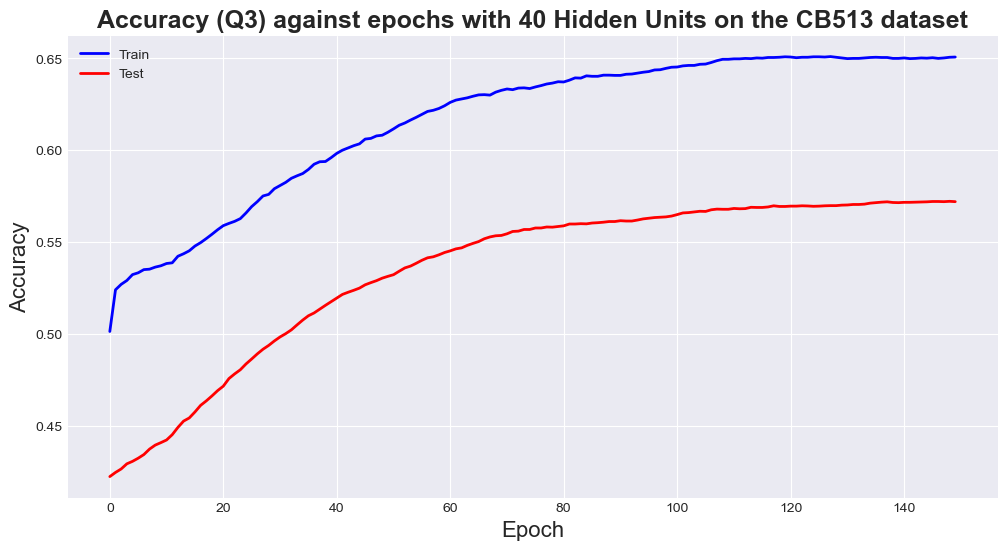

In [66]:
# plot history
def plot_history(history):
    
 # Set the style
    plt.style.use('seaborn-v0_8-dark')  # Using a clean and professional style

    # Create figure and set size
    plt.figure(figsize=(12, 6))
    
    # Plot training & validation accuracy
    plt.plot(history.history['accuracy'], linestyle='-', color='blue', linewidth=2)
    plt.plot(history.history['val_accuracy'], linestyle='-', color='red', linewidth=2)
    plt.title('Accuracy (Q3) against epochs with 40 Hidden Units on the CB513 dataset', fontsize=18, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.grid(True)
    
    # save the plot
    plt.savefig('figures/original_model_accuracy_40_units_cb513.png',dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

plot_history(history)  